In [1]:
import pandas as pd
import numpy as np
from glob import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

## datasets
[kaggle-eCommerce behavior data from multi category store](https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store)

In [103]:
df = pd.read_parquet('ecommerce_down.parquet.gzip')

print(df.shape)
df.info()

(109950743, 9)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 109950743 entries, 0 to 67501978
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float32
 7   user_id        int64  
 8   user_session   object 
dtypes: float32(1), int64(3), object(5)
memory usage: 7.8+ GB


In [3]:
df["product_id"] = pd.to_numeric(df["product_id"], downcast="unsigned")
df["category_id"] = pd.to_numeric(df["category_id"], downcast="unsigned")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109950743 entries, 0 to 67501978
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     uint32 
 3   category_id    uint64 
 4   category_code  object 
 5   brand          object 
 6   price          float32
 7   user_id        int64  
 8   user_session   object 
dtypes: float32(1), int64(1), object(5), uint32(1), uint64(1)
memory usage: 7.4+ GB


### `RFM(Recency, Frequency, Monetary)`

* RFM은 가치있는 고객을 추출해내어 이를 기준으로 고객을 분류할 수 있는 매우 간단하면서도 유용하게 사용될 수 있는 방법으로 알려져 있어 마케팅에서 가장 많이 사용되고 있는 분석방법 중 하나이다. RFM은 구매 가능성이 높은 고객을 선정하기 위한 데이터 분석방법으로서, 분석과정을 통해 데이터는 의미있는 정보로 전환된다.

* RFM은 Recency, Frequency, Monetary의 약자로 고객의 가치를 다음의 세 가지 기준에 의해 계산하고 있다.

* Recency - 거래의 최근성: 고객이 얼마나 최근에 구입했는가?
* Frequency - 거래빈도: 고객이 얼마나 빈번하게 우리 상품을 구입했나?
* Monetary - 거래규모: 고객이 구입했던 총 금액은 어느 정도인가?

In [4]:
# 데이터 중복 확인하기.
df[df.duplicated(keep=False)]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
3829,2019-10-01 02:25:40 UTC,view,1307116,2053013558920217191,computers.notebook,hp,463.070007,548049635,83085f41-22c3-4f27-bc29-bfaaf460d902
3830,2019-10-01 02:25:40 UTC,view,1307116,2053013558920217191,computers.notebook,hp,463.070007,548049635,83085f41-22c3-4f27-bc29-bfaaf460d902
3831,2019-10-01 02:25:40 UTC,view,1307116,2053013558920217191,computers.notebook,hp,463.070007,548049635,83085f41-22c3-4f27-bc29-bfaaf460d902
3832,2019-10-01 02:25:40 UTC,view,1307116,2053013558920217191,computers.notebook,hp,463.070007,548049635,83085f41-22c3-4f27-bc29-bfaaf460d902
8564,2019-10-01 02:34:48 UTC,view,17200828,2053013559792632471,furniture.living_room.sofa,None,926.409973,555464369,8bf38319-436a-4637-8c84-6de4213f8a13
...,...,...,...,...,...,...,...,...,...
67496099,2019-11-30 23:23:19 UTC,cart,1004767,2053013555631882655,electronics.smartphone,samsung,235.600006,557430626,c94ec09c-f90e-4a2a-8eae-03adf0545f51
67500479,2019-11-30 23:49:38 UTC,cart,17300809,2053013553853497655,None,lanvin,35.869999,514249707,065753d8-1aef-4395-822e-a767b6349c02
67500483,2019-11-30 23:49:38 UTC,cart,17300809,2053013553853497655,None,lanvin,35.869999,514249707,065753d8-1aef-4395-822e-a767b6349c02
67501608,2019-11-30 23:57:21 UTC,cart,1004767,2053013555631882655,electronics.smartphone,samsung,235.600006,574868869,878a1538-ebe3-4d7f-b773-1b057b1971eb


In [104]:
# 중복데이터 제거
df_net = df.drop_duplicates().copy()
df_net.shape

KeyboardInterrupt: 

In [6]:
df[df["event_type"] == "purchase"].user_id.nunique()

697470

In [7]:
# purchase만 추리기
df_purchase = df_net[df_net["event_type"] == "purchase"]

In [9]:
# 날짜 타입으로 바꾸기
df_purchase["event_time"] = pd.to_datetime(df_purchase["event_time"])

/var/folders/ls/xfm8y3_n5d53_dm2ngg7j1q40000gn/T/ipykernel_54285/1050543106.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_purchase["event_time"] = pd.to_datetime(df_purchase["event_time"])


In [11]:
# 최근 거래 기준일 구하기 (최소값:1 설정)
import datetime as dt
last_timestamp = df_purchase["event_time"].max() + dt.timedelta(days=1)
last_timestamp

Timestamp('2019-12-01 23:59:44+0000', tz='UTC')

In [12]:
#rfm값 구하기
rfm = df_purchase.groupby("user_id").agg({"event_time" : lambda x : (last_timestamp - x.max()).days, 
                                          "event_type" : "count", 
                                          "price" : "sum"})
rfm

,event_time,event_type,price
user_id,,,
138340325,20,1,93.500000
225644257,19,1,40.910000
253299396,25,1,246.850006
256164170,11,1,113.230003
264649825,56,2,1240.040039
...,...,...,...
579962677,1,1,1634.380005
579963523,1,1,457.910004
579964521,1,1,334.600006


In [13]:
#컬럼명 변경
rfm.columns = ["Recency", "Frequency", "MonetaryValue"]
rfm

,Recency,Frequency,MonetaryValue
user_id,,,
138340325,20,1,93.500000
225644257,19,1,40.910000
253299396,25,1,246.850006
256164170,11,1,113.230003
264649825,56,2,1240.040039
...,...,...,...
579962677,1,1,1634.380005
579963523,1,1,457.910004
579964521,1,1,334.600006


In [26]:
df_purchase["user_id"].nunique()

697470

In [36]:
# Frequency를 qcut할 수 있는지 살펴보기
rfm["Frequency"].value_counts().sort_index()

1      402161
2      138673
3       59426
4       30763
5       17847
        ...  
312         1
367         1
376         1
589         1
640         1
Name: Frequency, Length: 176, dtype: int64

In [27]:
# 구매횟수가 1인 회원의 비중 구하기
402161 / 697470

0.5765997103818086

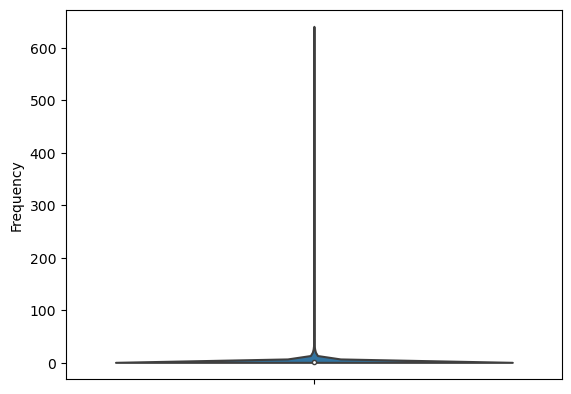

In [116]:
# plot 그려보기
sns.violinplot(data=rfm, y="Frequency");

In [42]:
# 구매횟수가 2이상인 회원의 개수 확인
rfm[rfm["Frequency"] >= 2]

,Recency,Frequency,MonetaryValue
user_id,,,
264649825,56,2,1240.040039
296197073,1,2,61.520000
315835135,2,3,393.160004
340041246,48,4,915.520020
366237542,3,2,300.160004
...,...,...,...
579930581,1,2,1183.500000
579935169,1,3,304.169983
579938955,1,4,496.440002


In [33]:
# Recency 결과값 확인
rfm["Recency"].value_counts().sort_index()

1     20064
2     20410
3     14101
4     13489
5     12681
6     12661
7     11620
8     10781
9     11650
10    11918
11    11474
12    11252
13    12640
14    95846
15    32023
17    10289
18     9852
19     9792
20    10843
21     9978
22     9709
23    10853
24    10304
25    10135
26    10103
27    10884
28     9031
29     8700
30     8555
31     7671
32     7794
33     7498
34     7939
35     8965
36     8730
37     8766
38     8777
39     8996
40     9080
41     8994
42     9108
43     8831
44     8632
45     9147
46    10373
47     8432
48     8751
49    10575
50     8858
51     8635
52     7092
53     7579
54     7413
55     7030
56     7703
57     7865
58     8562
59     5872
60     6054
61     6110
Name: Recency, dtype: int64

In [35]:
# MonetaryValue 결과값 확인
rfm["MonetaryValue"].value_counts().sort_index()

0.77000          1
0.79000          1
0.87000          2
0.88000         11
0.90000          1
                ..
203986.06250     1
265569.53125     1
266331.25000     1
303144.25000     1
343899.09375     1
Name: MonetaryValue, Length: 174974, dtype: int64

### `RFM 모형`
- R

In [15]:
r_labels = list(range(5, 0, -1))
# f_labels = list(range(1, 6))
m_labels = list(range(1, 6))

In [43]:
pd.qcut?

In [17]:
r_cut = pd.qcut(rfm["Recency"], 5, labels=r_labels)

In [45]:
f_cut = pd.qcut(rfm[rfm["Frequency"] >= 2].Frequency, 2, labels=[2,3])

In [18]:
m_cut = pd.qcut(rfm["MonetaryValue"], 5, labels=m_labels)

In [65]:
# assign으로 여러 변수를 한 번에 만들기.
rfm = rfm.assign(R=r_cut, F=f_cut, M=m_cut)
rfm

,Recency,Frequency,MonetaryValue,R,F,M
user_id,,,,,,
138340325,20,1,93.500000,3,NaN,2
225644257,19,1,40.910000,3,NaN,1
253299396,25,1,246.850006,3,NaN,3
256164170,11,1,113.230003,5,NaN,2
264649825,56,2,1240.040039,1,2,5
...,...,...,...,...,...,...
579962677,1,1,1634.380005,5,NaN,5
579963523,1,1,457.910004,5,NaN,4
579964521,1,1,334.600006,5,NaN,3


In [72]:
# F NAN에 1로 채우기
rfm["F"] = rfm["F"].astype("float")
rfm.loc[rfm["F"].isnull(), "F"] = 1
rfm["F"] = rfm["F"].astype("int")
rfm

,Recency,Frequency,MonetaryValue,R,F,M
user_id,,,,,,
138340325,20,1,93.500000,3,1,2
225644257,19,1,40.910000,3,1,1
253299396,25,1,246.850006,3,1,3
256164170,11,1,113.230003,5,1,2
264649825,56,2,1240.040039,1,2,5
...,...,...,...,...,...,...
579962677,1,1,1634.380005,5,1,5
579963523,1,1,457.910004,5,1,4
579964521,1,1,334.600006,5,1,3


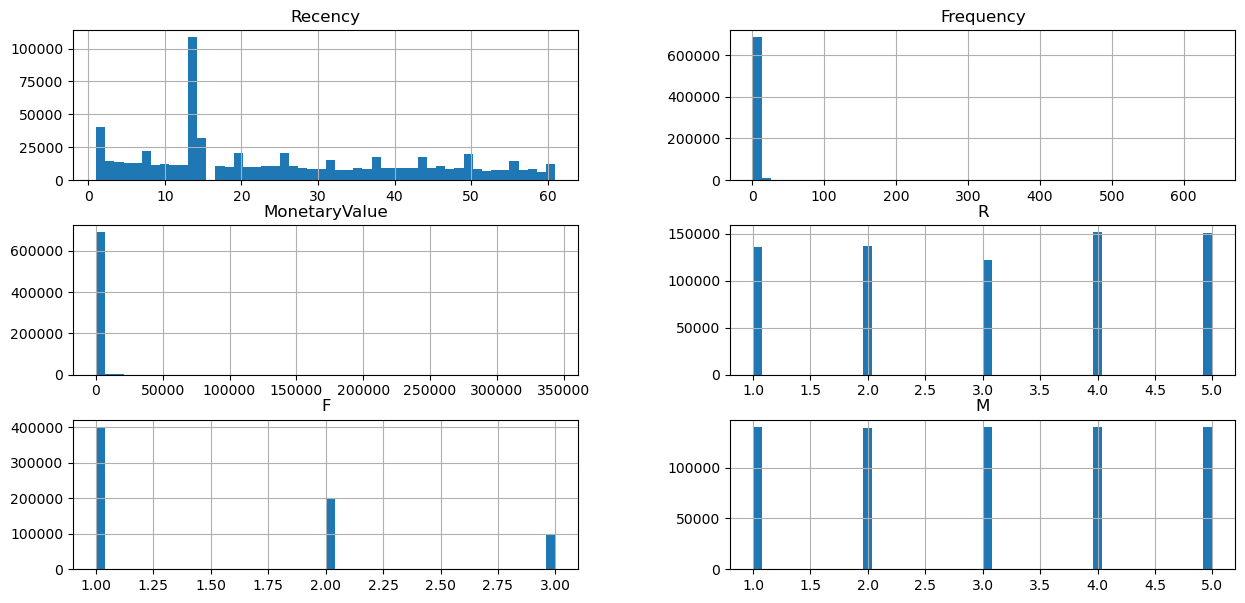

In [77]:
#히스토그램 그려보기
rfm.astype(float).hist(figsize=(15, 7), bins=50);

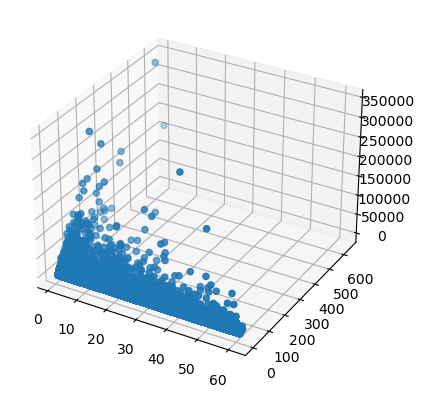

In [75]:
# rfm["Recency"], rfm["Frequency"], rfm["MonetaryValue"]
ax = plt.axes(projection='3d')
ax.scatter3D(rfm["Recency"], rfm["Frequency"], rfm["MonetaryValue"]);

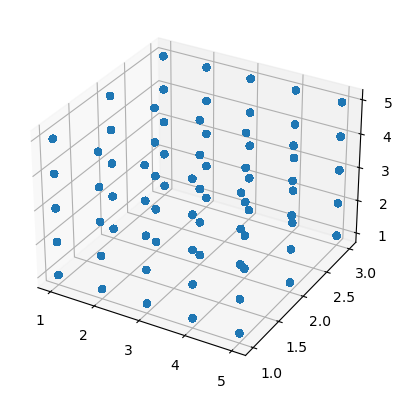

In [74]:
# 3d projection ax.scatter3D rfm["R"], rfm["F"], rfm["M"]
ax = plt.axes(projection='3d')
ax.scatter3D(rfm["R"], rfm["F"], rfm["M"]);

In [101]:
px.scattertter_3d(rfm, x="R", y="F", z="M")

AttributeError: module 'plotly.express' has no attribute 'scattertter_3d'

In [78]:
# RFM Segment (문자 그대로 붙이기)
rfm["RFM_segment"] = rfm["R"].astype(str) + rfm["F"].astype(str) + rfm["M"].astype(str)

# RFM Score (합계)
rfm["RFM_score"] = rfm[["R", "F", "M"]].sum(axis=1)
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score
user_id,,,,,,,,
138340325,20,1,93.500000,3,1,2,312,6
225644257,19,1,40.910000,3,1,1,311,5
253299396,25,1,246.850006,3,1,3,313,7
256164170,11,1,113.230003,5,1,2,512,8
264649825,56,2,1240.040039,1,2,5,125,8


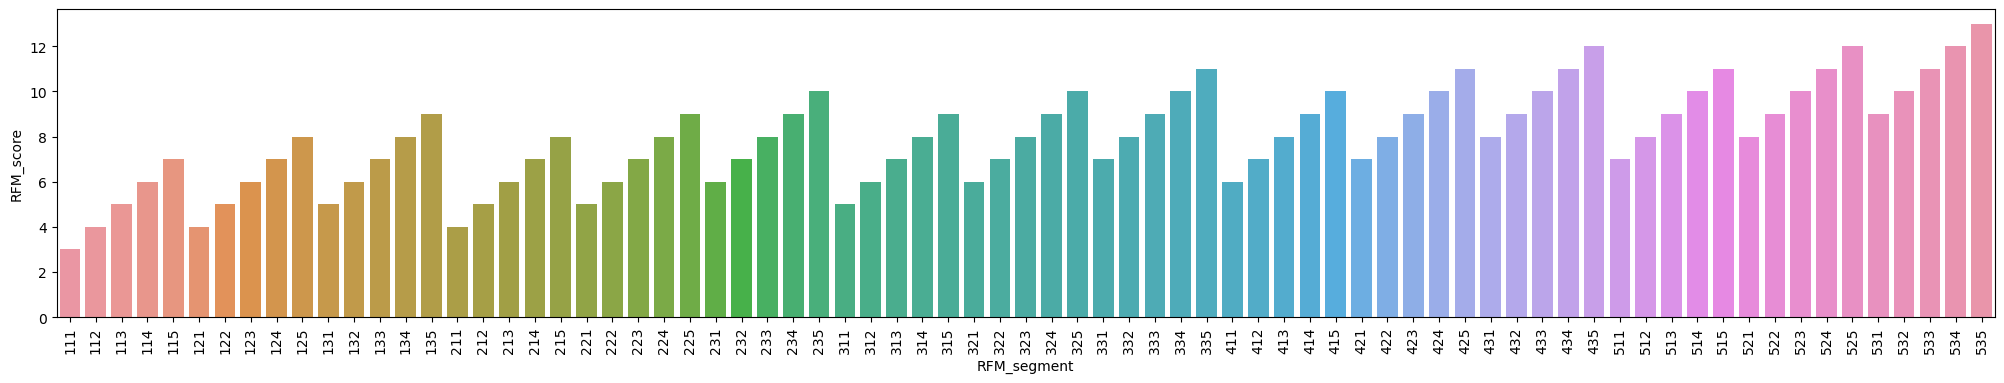

In [80]:
# RFM segment 값에 따라 정렬
plt.figure(figsize=(25, 4))
plt.xticks(rotation=90)
sns.barplot(data=rfm.sort_values("RFM_segment"), x="RFM_segment", y="RFM_score");

In [85]:
# RFM score 값에 따라 R,F,M 평균 확인
rfm.groupby("RFM_score").agg({"Recency" : "mean", "Frequency" : "mean", 
                              "MonetaryValue" : ["mean", "sum"]}
                            ).style.format('{:,.0f}').background_gradient()

### `고객등급 나누기`
- 자주 이용하는 ssg.com에서 회원등급을 Friends, Gold, VIP로 나누는 것을 차용해서 3단계로 나눠봄.

In [81]:
rfm["RFM_class"] = pd.qcut(rfm["RFM_score"], 3, labels=["Friends", "Gold", "VIP"])
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class
user_id,,,,,,,,,
138340325,20,1,93.500000,3,1,2,312,6,Friends
225644257,19,1,40.910000,3,1,1,311,5,Friends
253299396,25,1,246.850006,3,1,3,313,7,Gold
256164170,11,1,113.230003,5,1,2,512,8,Gold
264649825,56,2,1240.040039,1,2,5,125,8,Gold


In [82]:
# 회원 등급 확인하기
# 1. describe()
rfm.groupby("RFM_class")["RFM_score"].describe()

,count,mean,std,min,25%,50%,75%,max
RFM_class,,,,,,,,
Friends,248222.0,4.883834,1.020190,3.0,4.0,5.0,6.0,6.0
Gold,277133.0,7.907037,0.814588,7.0,7.0,8.0,9.0,9.0
VIP,172115.0,11.125195,1.086705,10.0,10.0,11.0,12.0,13.0


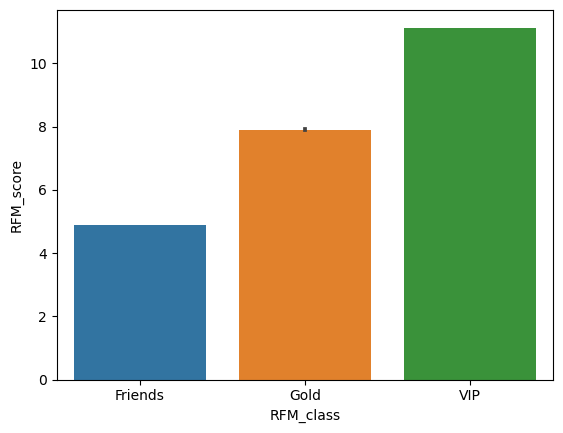

In [83]:
# 2. barplot 그려보기
sns.barplot(data=rfm, x="RFM_class", y="RFM_score");

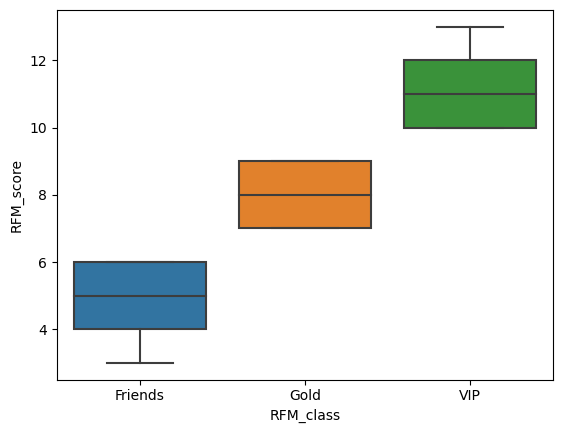

In [84]:
# 3. boxplot 그려보기
sns.boxplot(data=rfm, x="RFM_class", y="RFM_score");